In [1]:
import numpy as np
from statistics import mode

dataset = np.load("mnist.npz")
x_train = dataset['x_train']
y_train = dataset['y_train']
x_test = dataset['x_test']
y_test = dataset['y_test']

# Choose samples from 0 and 1 class in X & store the true label in Y_true
X = []
Y_true = []
count = {i: 0 for i in range(2)}
for i in range(len(x_train)):
    if (y_train[i] == 0 or y_train[i] == 1):
        count[y_train[i]]+=1
        Y_true.append(y_train[i])
        X.append(x_train[i].flatten())
X_array = np.array(X)

# print(X_array.shape)
# print(len(Y_true))
# print(count)


# Divide the train set into train and val set
for i in range(len(Y_true)): # relabeling 0 as -1
    if (Y_true[i]==0):
        Y_true[i] = -1
        
val0=0
val1=0
x=[]
y=[]
x_val = []
y_val = []
count_train = {i: 0 for i in [-1,1]}
count_val = {i: 0 for i in [-1,1]}
for i in range(len(Y_true)):
    if (Y_true[i] == -1 and val0<1000):
        x_val.append(X_array[i].flatten())
        y_val.append(Y_true[i])
        val0+=1
        count_val[Y_true[i]]+=1
    elif (Y_true[i] == 1 and val1<1000):
        x_val.append(X_array[i].flatten())
        y_val.append(Y_true[i])
        val1+=1
        count_val[Y_true[i]]+=1
    else:
        x.append(X_array[i].flatten())
        y.append(Y_true[i])
        count_train[Y_true[i]]+=1
        
X_train = np.array(x)
y = np.array(y)
X_val = np.array(x_val)
y_val = np.array(y_val)

# print(X_train.shape)
# print(len(y))
# print(y.shape)
# print(count_train)

# print(X_val.shape)
# print(len(y_val))
# print(y_val.shape)
# print(count_val)

# print(y)
# print(y_val)



# Applying PCA on X_train 

mean = np.mean(X_train,axis = 0)
# print(mean)
X_array = X_train - mean # Centralized X
total_samples = len(y)

# covariance matrix
S = np.dot(X_array.T, X_array) / (total_samples-1)
# print(S.shape)

eigenvalues, eigenvectors = np.linalg.eig(S)

# Sort them in desc order on the basis of eigenvalues & create matrix U of eigenvectors
idxs = sorted([i for i in range(len(eigenvalues))], key = lambda x: -eigenvalues[x])

U = []
for i in idxs:
    U.append(eigenvectors.T[i])
    
U = np.array(U).T
# print(U.shape)
# print(X_array.shape)

p = 5
Up = U[:, :p]
# U_P Y = U_P (U_P'X)
# print(Up.shape)

# Y = U_p'X --> projected x_train i.e. dimensionally reduced dataset
Y = np.real(np.dot(Up.T, X_array.T)).T
# print(Y.shape)
# Y here is the reduced dimension dataset
Y = Y/255 # Normalizing
# print(Y)

# Y --> dimensionally reduced dataset of the x_train with dimensions 10665 X 5
# y --> true labels of samples in Y


# Applying PCA on X_val & store the true label in y_val

X_Tarray = X_val - mean
# print(X_Tarray.shape)
# print(len(y_val))

# Y = U_p'x_valtest --> projected x_valtest i.e. dimensionally reduced val dataset
Y_valtest = np.real(np.dot(Up.T, X_Tarray.T)).T
# print(Y_valtest.shape)
# Y_valtest here is the reduced dimension val test dataset
Y_valtest = Y_valtest/255 # Normalizing
# print(Y_valtest)

# Y_valtest --> dimensionally reduced dataset of the X_val with dimensions 2000 X 5
# y_val --> true labels of samples in Y_valtest

In [2]:
feature = []
midpoints_array = np.array([])
for k in range(5):
    feature = []
    for i in range(len(Y)):
        feature.append(Y[i][k])
    # print(len(feature))
    f = np.array(feature)
    sorted_f = np.sort(f)
    midpoints = (sorted_f[:-1] + sorted_f[1:]) / 2
    # print(len(midpoints))    
    midpoints_array = np.append(midpoints_array, midpoints)
# print(f)
# print(sorted_f)
# print(midpoints)  
print(midpoints_array.shape) # 10664 (total_samples - 1) each for each dimension in chronological order

(53320,)


In [36]:
learning_rate = 0.01
no_of_trees = 300

In [37]:
# Now, we have 53320 random midpoints (10664 for each dimension) & we have to find the best split with minimum SSR.

outer_shape = len(midpoints_array)
inner_shape = len(Y)
total = len(Y)-1 # no of midpoints in each dimension

# Initialize an empty array to store mean values of the left and right of the best split of that iteration
values = np.empty((no_of_trees, 2))

SSR_values = []
best_splitindex = []
best_dimensions= []
best_splitvalues = []

updated_label = np.copy(y)
residue = np.copy(y)

for t in range(no_of_trees):
    SSR_iteration = []  
    for k in range(5):
        for i in range(k*total,(k+1)*total):
            midvalue = midpoints_array[i]
            # Create masks based on the value of the kth feature
            mask_lower = Y[:, k] < midvalue
            mask_upper = Y[:, k] >= midvalue 
    
            # Split updated_label based on the masks
            
            Y_true_lower = updated_label[mask_lower]
            Y_true_upper = updated_label[mask_upper]    
                
            left_value = 0
            right_value = 0   
    
            # For the split, we have to compute the mean for each side, then assign that to it, and then compute the SSR error 
            if (len(Y_true_lower)>0):
                left_value = np.mean(Y_true_lower)
            if (len(Y_true_upper)>0):
                right_value = np.mean(Y_true_upper)
    
            # Compute predict array - h_t(x)
            predict = np.empty(inner_shape)
            # For samples in the lower part
            predict[mask_lower] = left_value
            # For samples in the upper part
            predict[mask_upper] = right_value
    
            # Compute the squared error
            squared_error = np.sum((predict - updated_label) ** 2)
            SSR_iteration.append(squared_error)
            # if (i%10000 == 0):
            #     print(i)

    # print(len(SSR_iteration))
    # print(min(SSR_iteration))
    SSR_values.append(min(SSR_iteration))
    best_split_index = np.argmin(SSR_iteration)
    best_splitindex.append(best_split_index)
    dim = best_split_index//total
    best_dimensions.append(dim)
    best_split_value = midpoints_array[best_split_index]
    best_splitvalues.append(best_split_value)

    # Now, have the best split, make that split and find the residue & update the labels for next iteration
    
    # Create masks based on the value of the kth feature
    # print(dim)
    # print(best_split_value)
    mask_lower = Y[:, dim] < best_split_value
    mask_upper = Y[:, dim] >= best_split_value
    # print(mask_lower)
    # print(mask_upper)
    
    Y_true_lower = updated_label[mask_lower]
    Y_true_upper = updated_label[mask_upper]  
    # print("Y_true_lower shape:", Y_true_lower)
    # print("Y_true_upper shape:", Y_true_upper)   
    
    left_value = 0
    right_value = 0   
    
    # For the split, we have to compute the mean for each side, then assign that to it, and then compute the residue
    if (len(Y_true_lower)>0):
        left_value = np.mean(Y_true_lower)
    if (len(Y_true_upper)>0):
        right_value = np.mean(Y_true_upper)

    values[t, 0] = left_value
    values[t, 1] = right_value
    # print("Left Value: ",left_value)
    # print("Right Value: ",right_value)
    # Compute predict array - h_t(x)
    predict = np.empty(inner_shape)
    # For samples in the lower part
    predict[mask_lower] = left_value
    # For samples in the upper part
    predict[mask_upper] = right_value

    # print(predict)
    # print(updated_label)
    # # Print some values to check
    # print("Example values in predict:")
    # print("Lower values:", predict[mask_lower][:5])  # Print first 5 values where mask_lower is True
    # print("Upper values:", predict[mask_upper][:5])  # Print first 5 values where mask_upper is True
    
    # Computing the residue --> y - learning_rate*h1(x)
    residue = residue - learning_rate * predict
    updated_label = np.sign(residue) # updating labels for next iteration

    if (t%10==0):
        print(t)
      


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [71]:
print(SSR_values)
print(best_splitindex)
print(best_dimensions)
print(best_splitvalues)


[199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829104257, 199.0606829

In [72]:
total_val = len(y_val)
val_predictions = np.empty((no_of_trees, total_val))
MSE_values = []

# Y_valtest --> dimensionally reduced dataset of the X_val with dimensions 2000 X 5
# y_val --> true labels of samples in Y_valtest

for t in range(no_of_trees):
    
    # Create masks based on the value of the dim th feature
    mask_lower = Y_valtest[:, best_dimensions[t]] < best_splitvalues[t]
    mask_upper = Y_valtest[:, best_dimensions[t]] >= best_splitvalues[t]
    
    # Compute prediction array - what are the predictions for the val set by h_i(x)
    predict = np.empty(total_val)
    # For samples in the lower part
    predict[mask_lower] = values[t][0]
    # For samples in the upper part
    predict[mask_upper] = values[t][1]
    
    val_predictions[t] = learning_rate * predict

    cumulative_sum = np.sum(val_predictions[:t+1], axis=0)

    # Compute the MSE
    squared_error = np.sum((y_val - cumulative_sum) ** 2)
    mse = squared_error/total_val
    # print(mse)
    MSE_values.append(mse)
    

In [73]:
print(MSE_values)

[0.9804435551652527, 0.9610833899314416, 0.9419195042985673, 0.9229518982666307, 0.9041805718356302, 0.8856055250055667, 0.8672267577764399, 0.8490442701482497, 0.8310580621209966, 0.8132681336946803, 0.795674484869301, 0.7782771156448585, 0.7610760260213525, 0.7440712159987832, 0.7272626855771511, 0.7106504347564558, 0.6942344635366969, 0.6780147719178751, 0.6619913598999901, 0.646164227483042, 0.6305333746670304, 0.615098801451956, 0.5998605078378182, 0.584818493824617, 0.569972759412353, 0.5553233046010255, 0.5408701293906352, 0.5266132337811812, 0.5125526177726645, 0.49868828136508403, 0.48502022455844085, 0.4715484473527342, 0.45827294974796473, 0.4451937317441316, 0.43231079334123557, 0.41962413453927616, 0.40713375533825386, 0.3948396557381679, 0.3827418357390192, 0.3708402953408071, 0.3591350345435319, 0.3476260533471934, 0.3363133517517917, 0.3251969297573269, 0.31427678736379894, 0.3035529245712075, 0.2930253413795532, 0.28269403778883556, 0.2725590137990549, 0.26262026941021

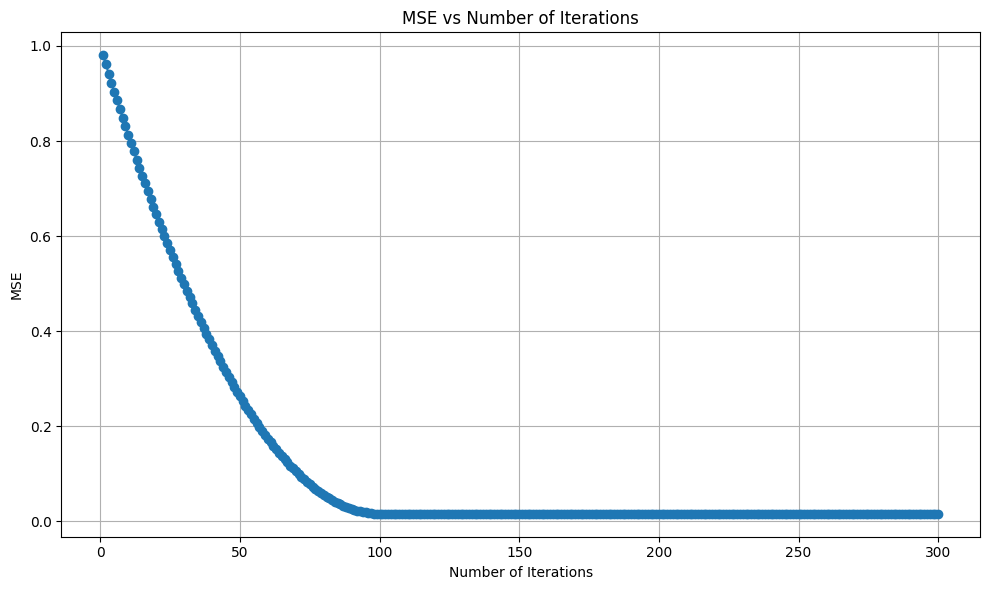

In [74]:
import matplotlib.pyplot as plt
iterations = np.arange(1, no_of_trees+1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, MSE_values, marker='o', linestyle='-')
plt.title('MSE vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
val_mse = np.array(MSE_values)
min_value = np.min(val_mse)
# Find all indices where the value is equal to the maximum value
min_indices = np.argwhere(val_mse == min_value).flatten()
min_index = np.min(min_indices)
print(f"Minimum Val Set MSE = {min_value} at {min_index+1} iterations")
print("Indices of minimum value:", min_indices)
print("Boosted tree with minimum val MSE: ", min_index+1)

Minimum Val Set MSE = 0.015764408980526466 at 299 iterations
Indices of minimum value: [298]
Boosted tree with minimum val MSE:  299


In [77]:
# Choose the test samples from 0 and 1 class in X_T & store their true label in Y_test_true
X_T =[]
Y_test_true = []
for i in range(len(x_test)):
    if (y_test[i] == 0 or y_test[i] == 1):
        Y_test_true.append(y_test[i])
        X_T.append(x_test[i].flatten())
X_Test = np.array(X_T)
X_Test = X_Test - mean
# print(X_Test.shape)
# print(len(Y_test_true))

for i in range(len(Y_test_true)): # relabeling 0 as -1
    if (Y_test_true[i]==0):
        Y_test_true[i] = -1

Y_True = np.array(Y_test_true)

# Y = U_p'x_test --> projected x_test i.e. dimensionally reduced test dataset
Y_test = np.real(np.dot(Up.T, X_Test.T)).T
# print(Y_test.shape)
# Y_test here is the reduced dimension test dataset
Y_test = Y_test/255 # Normalizing

# Y_test --> dimensionally reduced dataset of the X_Test with dimensions 2000 X 5
# Y_True --> true labels of samples in Y_Test

# Testing Best boosted tree on Test Set
total_test = len(Y_True)
test_predictions = np.empty((min_index, total_test))

for t in range(min_index):
    # Create masks based on the value of the dim th feature
    mask_lower = Y_test[:, best_dimensions[t]] < best_splitvalues[t]
    mask_upper = Y_test[:, best_dimensions[t]] >= best_splitvalues[t]
    
    # Compute prediction array - what are the predictions for the val set by h_i(x)
    predict = np.empty(total_test)
    # For samples in the lower part
    predict[mask_lower] = values[t][0]
    # For samples in the upper part
    predict[mask_upper] = values[t][1]
    
    test_predictions[t] = learning_rate * predict


cumulative_sum = np.sum(test_predictions[:min_index+1], axis=0)
# Compute the MSE
squared_error = np.sum((Y_True - cumulative_sum) ** 2)
mse = squared_error/total_test
# print(mse)
print(f"MSE on Test Set of Boosted tree with Minimum Val MSE = {mse}")

MSE on Test Set of Boosted tree with Minimum Val MSE = 0.015028905316582113
